**Text Cleaning**

In [1]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [2]:
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/schezro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/schezro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
dataset = pd.read_csv("../data/clean/merged-labeled/merged_labeled_dataset.csv")
dataset.head()

,reviews,sentiment
0,Looks durable Charging is fine tooNo complains...,Positive
1,I ordered this cable to connect my phone to An...,Positive
2,"Not quite durable and sturdy,https://m.media-a...",Positive
3,"Good product,long wire,Charges good,Nice,I bou...",Positive
4,"Bought this instead of original apple, does th...",Positive


In [4]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [5]:
import re
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.util import mark_negation
from nltk.stem import WordNetLemmatizer

# Initialize resources
lemmatizer = WordNetLemmatizer()

# Load stopwords and exclude negation words
stop_words = set(stopwords.words("english"))
# negation_words = {"no", "not", "never"}
# stop_words = stop_words - negation_words


def advance_text_cleaning(text: str) -> str:
    """
    Cleans the text using techniques: lowercasing, expanding contractions, 
    removing special characters, handling negations, removing stopwords, 
    lemmatization, and optional emoji removal.
    
    Args:  
        text (str): Input text to be cleaned.
        
    Returns:
        str: Cleaned and preprocessed text
    """

    if not isinstance(text, str):  
        return ""

    # Expand contractions (e.g., "can't" → "cannot")
    text = contractions.fix(text)
    
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)

    # Normalize repeated characters
    text = re.sub(r"(.)\1{2,}", r"\1", text)  # "loooove" → "love"
    
    # Remove emojis and special characters
    text = re.sub(r'[^\w\s]', '', text, flags=re.UNICODE)  # Removes emojis and other symbols
    
    # Remove special characters and numbers, retain only alphabets and spaces
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()

    # Convert to lowercase
    text = text.lower()

    # Tokenize text and handle negations    
    words = word_tokenize(text)
    # words = mark_negation(words)  # E.g., ["not", "good"] → ["not_good"]

    # Remove stopwords and lemmatize
    words = [
        lemmatizer.lemmatize(word)     
        for word in words
        if word not in stop_words  # Remove regular stopwords
        # and not (word.endswith("_NEG") and word[:-4] in stop_words)  # Remove negated stopwords
    ]

    # Convert tokens back to string
    return " ".join(words)


In [6]:
dataset["reviews"] = dataset["reviews"].apply(advance_text_cleaning)

In [7]:
dataset.head()

,reviews,sentiment
0,look durable charging fine toono complainschar...,Positive
1,ordered cable connect phone android auto car c...,Positive
2,quite durable sturdy good nice productworking ...,Positive
3,good productlong wirecharges goodnicei bought ...,Positive
4,bought instead original apple work r fast appl...,Positive


**Data Augmentation**

In [8]:
from nltk.corpus import wordnet
import random

In [9]:
def synonym_replacement(text: str, n: int = 2) -> str:
    """
    Replaces n words in the text with synonyms to augment the dataset.
    """
    words = text.split()
    new_words = words.copy()
    random.shuffle(words)
    
    replaced = 0
    for word in words:
        synonyms = wordnet.synsets(word)
        if synonyms and replaced < n:
            synonym = synonyms[0].lemmas()[0].name()
            new_words = [synonym if w == word else w for w in new_words]
            replaced += 1
            
    return " ".join(new_words)

In [10]:
augmented_data = dataset.copy()
augmented_data["reviews"] = augmented_data["reviews"].apply(lambda x: synonym_replacement(x, n=2))

In [11]:
augmented_data.head()

,reviews,sentiment
0,look durable charging fine toono complainschar...,Positive
1,ordered cable connect phone android auto car c...,Positive
2,quite durable sturdy good Nice productworking ...,Positive
3,good productlong wirecharges goodnicei bought ...,Positive
4,bought instead original apple work r fast appl...,Positive


In [12]:
# Combine original and augmented datasets
combined_dataset = pd.concat([dataset, augmented_data]).reset_index(drop=True)

In [13]:
from sklearn.utils import shuffle

# Shuffle the combined dataset
combined_dataset = shuffle(combined_dataset, random_state=42)

In [14]:
combined_dataset.head()

,reviews,sentiment
12795,point shoot camera work well problem far think...,Negative
7434,great phone,Positive
6497,variety pattern color ordered office chair sto...,Positive
3445,good price working well used galaxy note asus ...,Positive
11971,love card supply massive storage boost tablet ...,Positive


In [15]:
count = combined_dataset["reviews"].count()
count

15322

In [16]:
# Remove duplicate rows based on the 'cleaned_text' column
combined_dataset = combined_dataset.drop_duplicates(subset="reviews").reset_index(drop=True)

Implement Spell Correction

In [17]:
from symspellpy import SymSpell, Verbosity

# Initialize SymSpell
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

# Load a dictionary (ensure you have the file `frequency_dictionary_en_82_765.txt`)
sym_spell.load_dictionary("../data/frequency/frequency_dictionary_en_82_765.txt", term_index=0, count_index=1)

# Function to correct spelling
def correct_spelling(text: str) -> str:
    words = text.split()
    corrected_words = []
    for word in words:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        corrected_words.append(suggestions[0].term if suggestions else word)
    return " ".join(corrected_words)


In [18]:
combined_dataset["reviews"] = combined_dataset["reviews"].apply(correct_spelling)

In [19]:
combined_dataset["reviews"] = combined_dataset["reviews"].apply(advance_text_cleaning)

In [20]:
combined_dataset.head()

,reviews,sentiment
0,point shoot camera work well problem far think...,Negative
1,great phone,Positive
2,variety pattern color ordered office chair sto...,Positive
3,good price working well used galaxy note as al...,Positive
4,love card supply massive storage boost tablet ...,Positive


**Exploratory Data Analysis (EDA)**

In [21]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

Visualize sentiment distribution

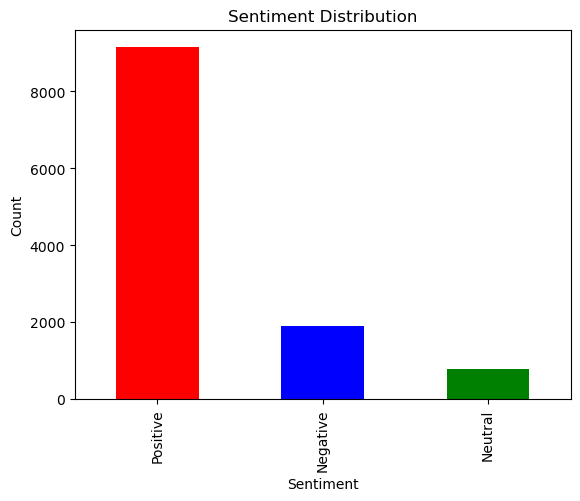

In [22]:
combined_dataset["sentiment"].value_counts().plot(kind="bar", title="Sentiment Distribution", color=["red", "blue", "green"])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

Create word clouds for each sentiment

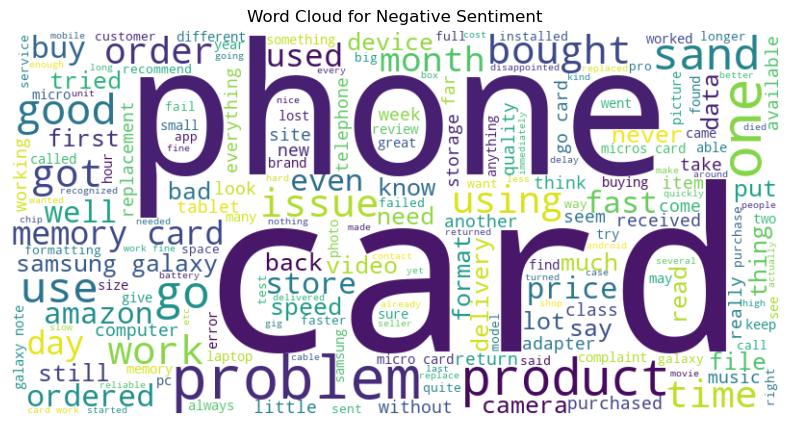

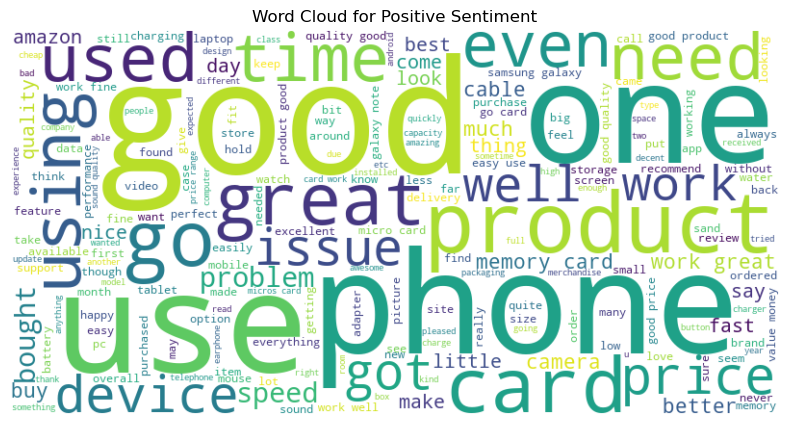

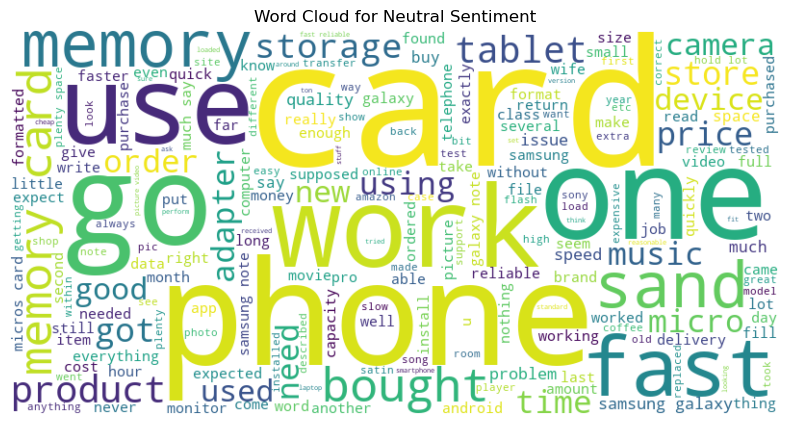

In [23]:
for sentiment in combined_dataset["sentiment"].unique():
    text = " ".join(combined_dataset[combined_dataset["sentiment"] == sentiment]["reviews"])
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {sentiment} Sentiment")
    plt.show()

In [24]:
# Save the cleaned data to a CSV file
combined_dataset.to_csv('../data/clean/merged-labeled/final_dataset.csv', index=False)